<a href="https://colab.research.google.com/github/shahriyarredlearn/MLLearning/blob/main/CSE_475_Lab_5a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pumpkin Leaf Disease Detection using CNNs and XAI using PyTorch



**This dataset and analysis has been published in COMPAS 2024 Conference**



This notebook demonstrates:

1. Custom CNN model from scratch for leaf disease detection.

2. Transfer learning models (VGG, MobileNetV2, EfficientNet, DenseNet121, InceptionNet).

3. Training with dataset augmentation and early stopping.

4. Visualization of training and validation loss curves.

5. Model evaluation with precision, recall, and F1-score.

6. XAI techniques: Grad-CAM, Grad-CAM++, Eigen-CAM, and LIME for model interpretation.

# CNN Models

## Import Required Libraries

In [2]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-bmmvev_m
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-bmmvev_m
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit a2a23f83916d1caa428c447890d7ed5870818341
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import zipfile
import os
from tqdm import tqdm  # Import tqdm for progress bars
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## Load and Prepare the Dataset

Assuming the dataset is structured in folders for each class, we'll set up PyTorch data loaders for training, validation, and testing. Ensure the dataset is unzipped and organized properly.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rifat963/pumpkin")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:31<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2


In [5]:
!ls /root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2

Augmented  Original


In [6]:
# Define data transformations

"""
# In case dataset is organized into train, test and valid use the following structure
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/content/Original'  # Update path accordingly
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

"""

# Otherwise use the following structure

# Define transformations with potential augmentations

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2/Original", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Visualize Example Images for Each Class

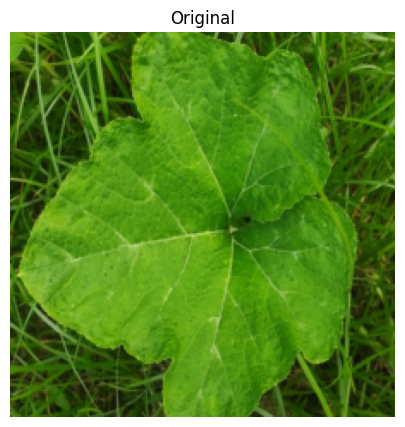

In [7]:
# Display a sample image from each class
class_names = dataset.classes
num_classes = len(class_names)

fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

# Dictionary to track displayed images per class
displayed_classes = {class_name: False for class_name in class_names}

# Loop through the data to get at least one sample from each class
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        # Display the image if not already displayed for this class
        if not displayed_classes[class_name]:
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Unnormalize the image

            # Fix: If axs is not subscriptable (num_classes = 1), use it directly
            if num_classes == 1:
                axs.imshow(np.clip(img, 0, 1))  # Clip to valid range
                axs.set_title(class_name)
                axs.axis('off')
            else:
                axs[label.item()].imshow(np.clip(img, 0, 1))  # Clip to valid range
                axs[label.item()].set_title(class_name)
                axs[label.item()].axis('off')

            displayed_classes[class_name] = True  # Mark as displayed

        # Break if all classes are displayed
        if all(displayed_classes.values()):
            break

    if all(displayed_classes.values()):
        break

plt.show()

## Define a Custom CNN Model

In [8]:
class CustomCNN(nn.Module):

    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, len(class_names))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 56 * 56)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


## Transfer Learning Models

Using pretrained models from PyTorch.

In [9]:
import torch.nn as nn
from torchvision import models

def get_transfer_model(model_name, num_classes):
    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "inception_v3":
        model = models.inception_v3(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final fully connected layer

    else:
        raise ValueError(f"Model '{model_name}' not supported. Choose from vgg16, mobilenet_v2, efficientnet_b0, densenet121, inception_v3, resnet50.")

    return model


## Training and Early Stopping

Include early stopping logic.

In [10]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Train the Model and Plot Loss Curves

## Training using Custom Model (Slow Without AMP)

In [11]:
# Set number of epochs and initialize variables

num_epochs = 10  # Define the number of training epochs

model = CustomCNN()  # Initialize the model; can replace with a transfer model like get_transfer_model()

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase

    model.train()  # Set model to training mode

    train_loss = 0  # Initialize cumulative training loss for the epoch

    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation

        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break


Epoch 1/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 2/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 3/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 4/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 5/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 6/10


Train Loss: 0.0000, Validation Loss: 0.0000
Early stopping triggered.


In [12]:
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


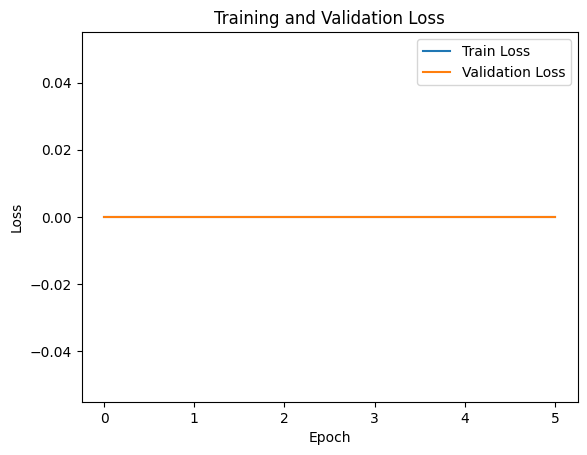

In [13]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

## Using AMP with Custom Model



To improve training speed, we can utilize Automatic Mixed Precision (AMP) provided by torch.cuda.amp. AMP enables faster training by using lower precision (float16) for parts of the computation while maintaining accuracy with some operations in higher precision (float32).

In [14]:
from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables

num_epochs = 10  # Define the number of training epochs

model = CustomCNN().to('cuda')  # Move model to GPU

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()  # Clear previous gradients
        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



<ipython-input-14-1f63a13528c4>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10


Training:   0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-14-1f63a13528c4>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-14-1f63a13528c4>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 2/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 3/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 4/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 5/10


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 6/10


Train Loss: 0.0000, Validation Loss: 0.0000
Early stopping triggered.


# Transfer Learning Example using ResNet50

In [15]:
from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables
num_epochs = 50  # Define the number of training epochs

model = get_transfer_model('resnet50', num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU

        optimizer.zero_grad()  # Clear previous gradients

        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



# Save the model
torch.save(model.state_dict(), 'transfer_learning_resnet50.pth')
print("Model saved as 'transfer_learning_resnet50.pth'")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]
<ipython-input-15-6806ae329086>:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-15-6806ae329086>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/13 [00:00<?, ?it/s]<ipython-input-15-6806ae329086>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 2/50


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 3/50


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 4/50


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 5/50


Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 6/50


Train Loss: 0.0000, Validation Loss: 0.0000
Early stopping triggered.
Model saved as 'transfer_learning_resnet50.pth'


## Loss Curve for ResNet50

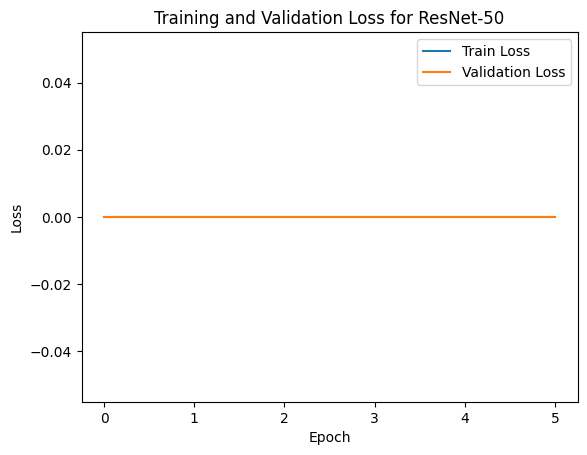

In [16]:
# Plotting loss curves

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for ResNet-50")
plt.show()

# Model Evaluation and Metrics Calculation

In [17]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 100.00%
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


# XAI - Grad-CAM, Grad-CAM++, Eigen-CAM

**1. Grad-CAM (Gradient-weighted Class Activation Mapping)**
Grad-CAM uses gradients flowing back from a target class to the last convolutional layer of a model to generate a heatmap. This heatmap highlights the areas in the image that are most relevant to the model's classification for a particular class.

* **How It Works:** Grad-CAM computes the gradients of the target class score concerning the feature maps of a convolutional layer. These gradients are globally pooled to get a single weight for each feature map. Then, each feature map is multiplied by its corresponding weight, and all feature maps are summed up. Finally, ReLU is applied to keep only the positive influences.
* **Interpretation:** The resulting heatmap shows which regions contribute positively to the model's confidence for the specified class. This approach is class-discriminative, meaning it highlights areas of the image that correspond specifically to the predicted class.

**2. Grad-CAM++**
Grad-CAM++ is an extension of Grad-CAM that refines the heatmap to provide more detailed localization, especially in cases where multiple objects are present or when the object of interest is not dominant in the image.

* **How It Works:** Grad-CAM++ introduces additional weighting terms to account for each pixel's importance in the feature maps. It calculates pixel-wise weights rather than global weights for each feature map. These pixel-wise weights are derived from higher-order gradients, allowing Grad-CAM++ to better capture complex and subtle details in an image.
* **Interpretation:** Grad-CAM++ often produces sharper, more localized heatmaps, which can be especially useful in medical imaging, fine-grained classification, or images with multiple objects of interest.

**3. Eigen-CAM**
Eigen-CAM is a technique based on Principal Component Analysis (PCA) of the feature maps, rather than using gradients, to produce a heatmap. It’s an unsupervised approach that doesn’t depend on any specific target class and is class-agnostic.

* **How It Works:** Eigen-CAM applies PCA to the feature maps from a chosen convolutional layer. It uses the principal eigenvector of these feature maps to identify regions of high variance, which often correlate with regions that the model finds significant for any class. The resulting heatmap highlights the parts of the image that contribute most to the model’s general activations, rather than to a specific class.
* **Interpretation:** Since it’s class-agnostic, Eigen-CAM is ideal for understanding the general features in an image that activate a model, regardless of class. This is useful for cases where we want to understand model behavior without biasing it toward a particular prediction.


In [18]:
# Load the fine-tuned ResNet-50 model
num_classes = len(dataset.classes)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("transfer_learning_resnet50.pth"))
model = model.to('cuda')
model.eval()  # Set model to evaluation mode

# Select a sample image from the test dataset
sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

# Convert sample image to numpy for visualization
original_image_np = sample_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5  # Unnormalize
original_image_np = np.clip(original_image_np, 0, 1)

# Set up Grad-CAM, Grad-CAM++, and Eigen-CAM
target_layers = [model.layer4[-1]]

# Initialize CAM methods
gradcam = GradCAM(model=model, target_layers=target_layers)
gradcam_plus_plus = GradCAMPlusPlus(model=model, target_layers=target_layers)
eigen_cam = EigenCAM(model=model, target_layers=target_layers)

# Run inference to get the predicted class
with torch.no_grad():
    outputs = model(sample_image)
    predicted_class = outputs.argmax().item()
    predicted_class_name = class_names[predicted_class]  # Get the class name

# Define the target class for CAM methods
target = [ClassifierOutputTarget(predicted_class)]

# Generate heatmaps using Grad-CAM, Grad-CAM++, and Eigen-CAM
gradcam_heatmap = gradcam(input_tensor=sample_image, targets=target)[0]
gradcam_pp_heatmap = gradcam_plus_plus(input_tensor=sample_image, targets=target)[0]
eigen_cam_heatmap = eigen_cam(input_tensor=sample_image, targets=target)[0]

# Overlay the heatmaps on the original image
gradcam_result = show_cam_on_image(original_image_np, gradcam_heatmap, use_rgb=True)
gradcam_pp_result = show_cam_on_image(original_image_np, gradcam_pp_heatmap, use_rgb=True)
eigen_cam_result = show_cam_on_image(original_image_np, eigen_cam_heatmap, use_rgb=True)


<ipython-input-18-e2780faa7b69>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transfer_learning_resnet50.pth"))


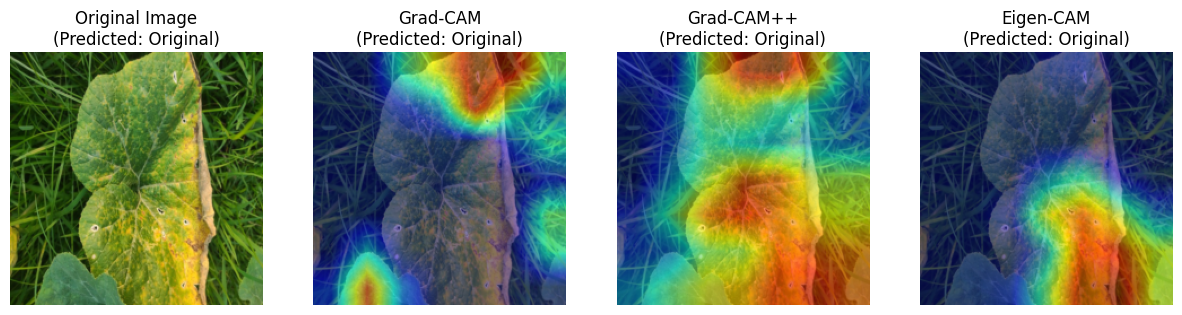

In [19]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(original_image_np)
plt.title(f"Original Image\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(gradcam_result)
plt.title(f"Grad-CAM\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(gradcam_pp_result)
plt.title(f"Grad-CAM++\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(eigen_cam_result)
plt.title(f"Eigen-CAM\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.show()

## LIME

**Purpose:** LIME explains a model’s prediction for a specific image by highlighting important regions that influenced the prediction.

**How Users Can Understand the Classification Output with LIME:**

**Highlighted Regions:** LIME’s heatmap shows which parts of the image were most important to the model’s decision. Brighter or colored areas on the heatmap indicate regions that strongly support the model's prediction.
**Interpretation:** By viewing these highlighted regions, users can understand what the model "focused on" to make its prediction. For example, if a model predicts "dog" and LIME highlights the face and body, it indicates these parts were most relevant to the model’s decision.

<ipython-input-20-b0b4a907e105>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transfer_learning_resnet50.pth"))


  0%|          | 0/100 [00:00<?, ?it/s]

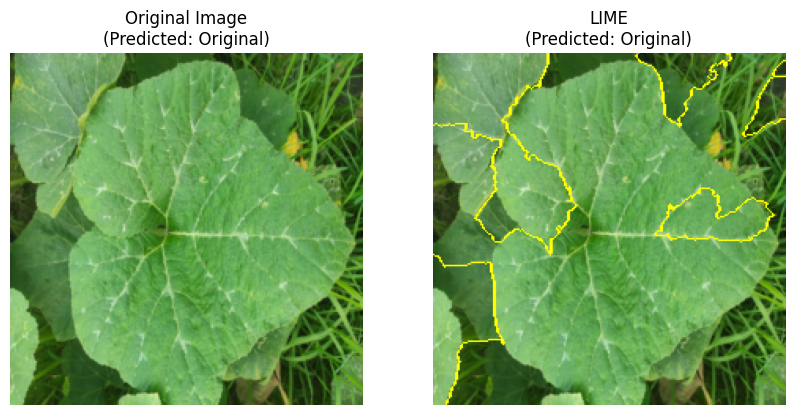

In [20]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image



# Load the fine-tuned ResNet-50 model
num_classes = len(dataset.classes)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("transfer_learning_resnet50.pth"))
model = model.to('cuda')
model.eval()

# Select a sample image from the dataset and preprocess it for display
sample_image, _ = dataset[0]  # Get the first image from the dataset
original_image_np = sample_image.permute(1, 2, 0).cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5  # Unnormalize
original_image_np = np.clip(original_image_np, 0, 1)  # Ensure valid range [0, 1]

# Define a function to make predictions for LIME
def batch_predict(images):
    model.eval()
    # Convert numpy arrays to PIL images and apply transformations
    batch = torch.stack([transform_test(Image.fromarray((image * 255).astype(np.uint8))) for image in images], dim=0).to('cuda')
    with torch.no_grad():
        logits = model(batch)
    return logits.cpu().numpy()

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate LIME explanation for the sample image
lime_explanation = explainer.explain_instance(
    original_image_np,  # Original image in numpy format
    batch_predict,      # Prediction function
    top_labels=1,       # Focus on the top predicted class
    hide_color=0,
    num_samples=100    # Number of perturbed samples
)

# Get the image and mask for the predicted class
predicted_class = model(sample_image.unsqueeze(0).to('cuda')).argmax().item()
lime_image, lime_mask = lime_explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)
lime_image = mark_boundaries(lime_image, lime_mask)

# Display the original and LIME result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title(f"Original Image\n(Predicted: {class_names[predicted_class]})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lime_image)
plt.title(f"LIME\n(Predicted: {class_names[predicted_class]})")
plt.axis("off")

plt.show()
